In [8]:
# imoprt libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import librosa # main package for working with Audio Data
import librosa.display
import tensorflow as tf
import IPython
import IPython.display as ipd # to play the Audio Files

from tensorflow import keras
from keras.models import Sequential
from keras import models, layers, regularizers
from glob import glob # allows us to list all files to a directory
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier  # Import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
encoder = LabelEncoder()
scaler = StandardScaler()


In [9]:
# Read the CSV file
df = pd.read_csv("content/features_3_sec.csv")

# Step 1: Extract group identifier and sequence number
df['group'] = df['filename'].apply(lambda x: '.'.join(x.split('.')[:2]))
df['seq_num'] = df['filename'].apply(lambda x: x.split('.')[2])

# Step 2: Group the DataFrame by the extracted group identifier
groups = df.groupby('group')

# Step 3 & 4: Find groups to delete
groups_to_delete = []
for name, group in groups:
    # Create a set of sequence numbers that should exist
    expected_seq_nums = set([str(i) for i in range(10)])
    
    # Find the set of sequence numbers in the current group
    actual_seq_nums = set(group['seq_num'])
    
    # If the difference between expected and actual is not empty, mark for deletion
    if expected_seq_nums - actual_seq_nums:
        groups_to_delete.append(name)

# Step 5: Delete marked groups from DataFrame
df = df[~df['group'].isin(groups_to_delete)].drop(columns=['group', 'seq_num'])

# df now contains only complete groups


In [10]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [11]:
df.shape # see the shape of df

(9900, 60)

In [12]:
df.info() # infos about the samples, features and datatypes

<class 'pandas.core.frame.DataFrame'>
Index: 9900 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9900 non-null   object 
 1   length                   9900 non-null   int64  
 2   chroma_stft_mean         9900 non-null   float64
 3   chroma_stft_var          9900 non-null   float64
 4   rms_mean                 9900 non-null   float64
 5   rms_var                  9900 non-null   float64
 6   spectral_centroid_mean   9900 non-null   float64
 7   spectral_centroid_var    9900 non-null   float64
 8   spectral_bandwidth_mean  9900 non-null   float64
 9   spectral_bandwidth_var   9900 non-null   float64
 10  rolloff_mean             9900 non-null   float64
 11  rolloff_var              9900 non-null   float64
 12  zero_crossing_rate_mean  9900 non-null   float64
 13  zero_crossing_rate_var   9900 non-null   float64
 14  harmony_mean             9900

In [13]:
df.isnull().sum() # checking for missing values

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

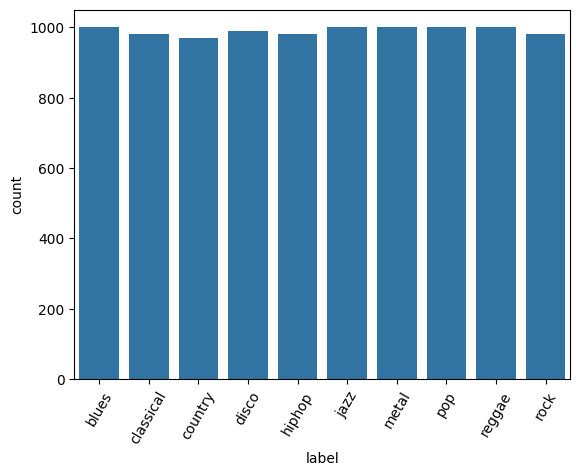

In [14]:
sns.countplot(x=df.label) # plot the categories
plt.xticks(rotation=60);

In [15]:
df = df.drop(labels='filename',axis=1)
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [16]:
data = df.iloc[:, :-1] # get the other columns
data

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [17]:
labels = df.iloc[:, -1] # get labels column
labels.to_frame()

,label
0,blues
1,blues
2,blues
3,blues
4,blues
...,...
9985,rock
9986,rock
9987,rock
9988,rock


In [18]:
x = np.array(data, dtype = float)
x = scaler.fit_transform(data)
y = encoder.fit_transform(labels)
x.shape, y.shape

((9900, 58), (9900,))

In [19]:
# split data to train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6633, 58), (3267, 58), (6633,), (3267,))

In [20]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert data to a numpy array and normalize
scaler = MinMaxScaler()
x = np.array(data, dtype=float)
x = scaler.fit_transform(x)

# Convert labels to a numpy array and encode
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
y = to_categorical(y)

# Parameters for non-overlapping sequences
time_steps = 10
number_of_samples = x.shape[0] // time_steps
number_of_features = x.shape[1]

# Reshape data for LSTM: Create non-overlapping sequences of 10 time-steps
x_lstm = np.array([x[i * time_steps:(i + 1) * time_steps] for i in range(number_of_samples)])
# Select labels for each sequence. Assuming each sequence's label corresponds to the label of its last time-step
y_lstm = np.array([y[i * time_steps + time_steps - 1] for i in range(number_of_samples)])

x_lstm.shape, y_lstm.shape


((990, 10, 58), (990, 10))

Epoch 1/50


/Users/james/Desktop/Machine Learning/project/ktuner-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2312 - loss: 2.2015 - val_accuracy: 0.3687 - val_loss: 1.8371
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4684 - loss: 1.6329 - val_accuracy: 0.4545 - val_loss: 1.4767
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5902 - loss: 1.2442 - val_accuracy: 0.5556 - val_loss: 1.2569
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6969 - loss: 0.9267 - val_accuracy: 0.6061 - val_loss: 1.1307
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7351 - loss: 0.7656 - val_accuracy: 0.6667 - val_loss: 1.0379
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8244 - loss: 0.5728 - val_accuracy: 0.6818 - val_loss: 1.0489
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8269 - loss: 0.5288 - val_accuracy: 0.7273 - val_loss: 0.9414
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8726 - loss: 0.3959 - val_accuracy: 0.7172 - val_loss: 1.0065
Ep

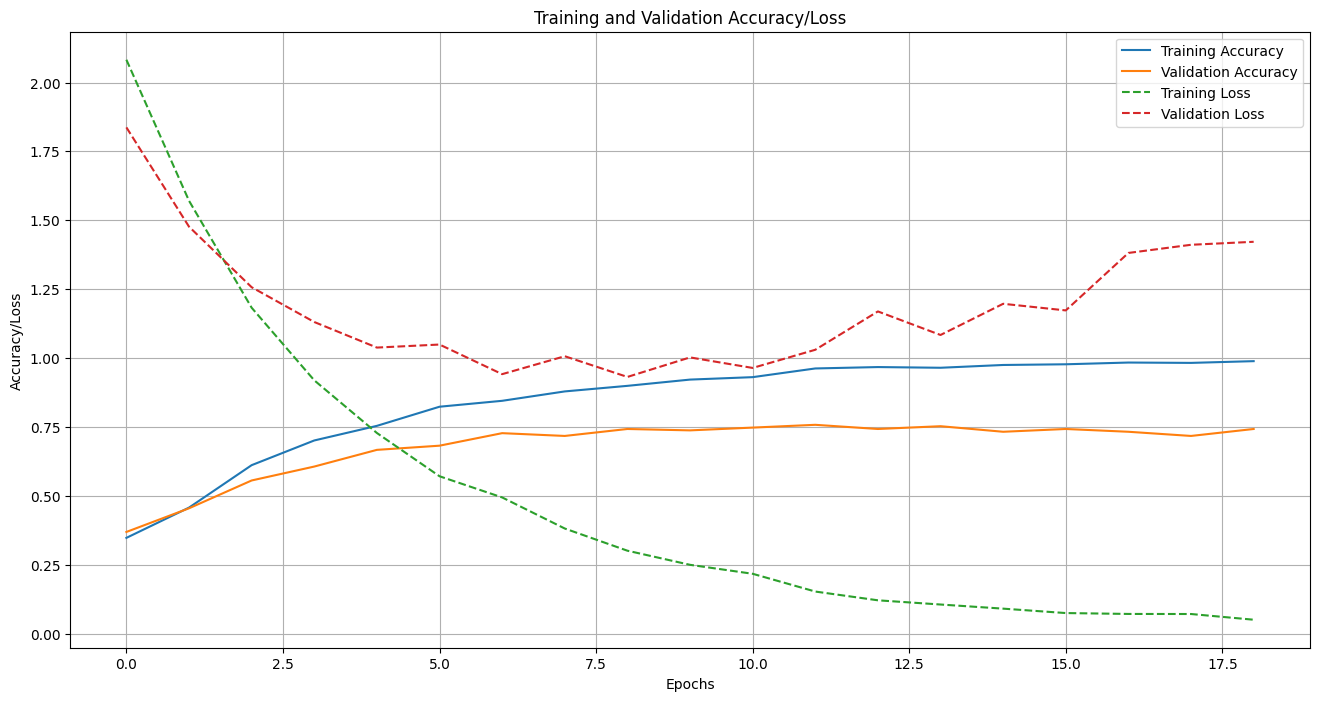

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


num_samples, time_steps, num_features = x_lstm.shape

y_onehot = y_lstm

# Scale the data
X_reshaped = x_lstm.reshape(-1, num_features)
scaler = StandardScaler().fit(X_reshaped)
X_scaled_reshaped = scaler.transform(X_reshaped)
X_scaled = X_scaled_reshaped.reshape(num_samples, time_steps, num_features)

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(time_steps, num_features), return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_onehot.shape[1], activation='softmax')  # Assuming y_onehot is already one-hot encoded
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the validation data
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plotting training and validation accuracy and loss
history_data = history.history
plt.figure(figsize=(16, 8))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.plot(history_data['loss'], label='Training Loss', linestyle='--')
plt.plot(history_data['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Accuracy/Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.grid(True)
plt.show()
